# Notebook Goal

* Understand how can we process 3D data as a point cloud in 3D space. 
* This data can be received from LIDARs, RADARs, Stereo or Depth cameras.


**OBS:** If you like the notebook, upvote it! :D

# 3D data representation

We can have 3D data presented as:

* [Rasterized](https://en.wikipedia.org/wiki/Rasterisation) format:
    * RGB-D
    * Volumetric
    * Multi-view

* Geometric format:
    * Point Cloud
    * Graphs
    * Meshes

# Popular Deep Networks Models

The most popular networks used for this porpose are:

* [Multiview CNN](https://openaccess.thecvf.com/content_cvpr_2016/papers/Qi_Volumetric_and_Multi-View_CVPR_2016_paper.pdf) (create multiples views and process them in CNNs)

* [Volumetric CNN](https://openaccess.thecvf.com/content_cvpr_2016/papers/Qi_Volumetric_and_Multi-View_CVPR_2016_paper.pdf) (Processes 3D data natively in CNNs by voxelizing the 3D data)
    * Voxel CNN
    * Octree CNN
    
* Point Network
    * PointNet
    * Convolution-based methods
    * Graph based methods

# The Problem

* Can we classify the 3D mnist dataset using 3D point cloud data as input and categories as output?


# The Data

* Setting seed to get reproducible results

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

# Random number generator seed
np.random.seed(42)
np.set_printoptions(precision=4)
tf.random.set_seed(42)
keras.utils.set_random_seed(seed=42)

# Mixed precision precision (float16)
keras.mixed_precision.set_global_policy("mixed_float16")

2024-08-08 09:57:20.363338: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-08 09:57:20.382938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 09:57:20.404558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 09:57:20.411749: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 09:57:20.428463: I tensorflow/core/platform/cpu_feature_guar

## Load Dataset

* From the kaggle dataset [datacard](https://www.kaggle.com/datasets/daavoo/3d-mnist/data) we have 3 databases.
    1. "full_dataset_vectors.h5" which contains the full dataset as voxel data with shape (16, 16, 16) separated into train and test sets.
    2. "train_point_cloud.h5" which contains the train dataset containing the (x, y, z), (nx, ny, nz), image and label.
    3. "test_point_cloud.h5" has the same structure as "train_point_cloud.h5".

In [2]:
# Thanks for this auxiliar funtions to
## https://www.kaggle.com/code/rajeevctrl/3d-mnist-classification-using-pointcloud-and-voxel

def vector_to_voxel(vector, shape=(16,16,16)):
    vec_shape = list(vector.shape[:-1]) + list(shape)
    voxel = vector.reshape(*vec_shape)
    return voxel

def voxel_to_pointcloud(voxel, num_points=None, shuffle=True):
    assert len(voxel.shape)==3, f"Voxel should be a 3D tensor. Given shape {voxel.shape}!=3"
    x, y, z = np.nonzero(voxel)
    point_cloud = np.concatenate([np.expand_dims(x,axis=1), np.expand_dims(y,axis=1), np.expand_dims(z,axis=1)], axis=1)
    if num_points is not None:
        if point_cloud.shape[0] >= num_points:
            ids = list(range(point_cloud.shape[0]))
            ids = ids[:num_points] if shuffle==False else np.random.permutation(ids)[:num_points]
            point_cloud = point_cloud[ids,:]
        else:
            diff = num_points - len(point_cloud)
            padding = np.zeros([diff, 3])
            point_cloud = np.concatenate([point_cloud, padding], axis=0)
            ids = list(range(len(point_cloud)))
            ids = ids[:num_points] if shuffle==False else np.random.permutation(ids)[:num_points]
            point_cloud = point_cloud[ids,:]        
    return point_cloud

def vector_to_pointcloud(vector, num_points=None, shuffle=True):
    voxel = vector_to_voxel(vector)
    voxel = np.squeeze(voxel)
    point_cloud = voxel_to_pointcloud(voxel, num_points, shuffle)
    return point_cloud

### Voxel Dataset

In [3]:
voxel_dataset_path = "datasets/3d_mnist/full_dataset_vectors.h5"

if os.path.exists(voxel_dataset_path) and os.path.isfile(voxel_dataset_path):
    with h5py.File(voxel_dataset_path, 'r') as hf:
        print(list(hf.keys()))
        voxel_X_train = hf['X_train'][:]
        y_train = hf['y_train'][:]
        voxel_X_test = hf['X_test'][:]
        y_test = hf['y_test'][:]

        print(voxel_X_train.shape, voxel_X_test.shape)

        voxel_X_train = voxel_X_train.reshape(-1, 16, 16, 16)
        voxel_X_test = voxel_X_test.reshape(-1, 16, 16, 16)

        print(voxel_X_train.shape, voxel_X_test.shape)

else:
    raise Exception("File not found")

['X_test', 'X_train', 'y_test', 'y_train']
(10000, 4096) (2000, 4096)
(10000, 16, 16, 16) (2000, 16, 16, 16)


### Getting categoric dummies

In [4]:
y_train_dummy = keras.utils.to_categorical(y_train, num_classes=10)
y_test_dummy = keras.utils.to_categorical(y_test, num_classes=10)

print(y_train_dummy.shape, y_test_dummy.shape)

(10000, 10) (2000, 10)


### Point Cloud Dataset

Label:  5
Shape:  (25700, 3)


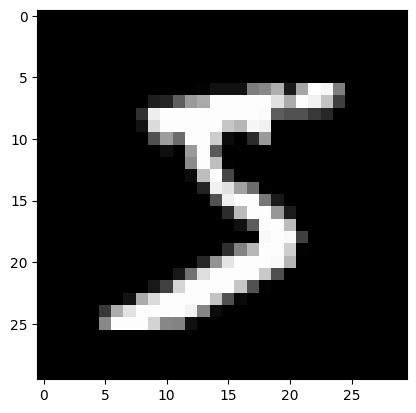

In [5]:
pointcloud_dataset_path = "datasets/3d_mnist/train_point_clouds.h5"

with h5py.File(pointcloud_dataset_path, 'r') as hf:
    item = hf[list(hf.keys())[0]]
    print("Label: ", item.attrs['label'])
    print("Shape: ", item['points'].shape)
    plt.imshow(item['img'], cmap='gray');


* Here we can see that the point cloud has 25700 points. Note that not all clouds have the same number of points.

In [12]:
# We set this to make all arrays the same size so we can work better with numpy
# I choose a lower number of points to make it work better on my GPU

NUM_POINTS = 250 

pointcloud_X_train = np.array([voxel_to_pointcloud(x, num_points=NUM_POINTS) for x in voxel_X_train])
pointcloud_X_test = np.array([voxel_to_pointcloud(x, num_points=NUM_POINTS) for x in voxel_X_test])

### Visualizing a single sample

In [24]:
import plotly.express as px
import pandas as pd

# Thanks for this function: 
## https://www.kaggle.com/code/rajeevctrl/3d-mnist-classification-using-pointcloud-and-voxel
def plot_3d_digit(image, digit, size=1, opacity=0.3):
    if isinstance(image, np.ndarray):
        x, y, z = np.nonzero(image)
        point_cloud = np.concatenate([np.expand_dims(x,axis=1), np.expand_dims(y,axis=1), np.expand_dims(z,axis=1)], axis=1)
        
        df = pd.DataFrame(point_cloud, columns=["x", "y", "z"])
    fig = px.scatter_3d(df, x="x", y="y", z="z", 
                        # size=[size]*len(df), 
                        opacity=opacity, 
                        title=f"Current digit is {digit}")
    fig.update_traces(marker_size = size)
    fig.show()

In [30]:
index = np.random.randint(0, voxel_X_train.shape[0])

label = y_train[index]
image = voxel_X_train[index]

plot_3d_digit(image, label, size=2, opacity=1)

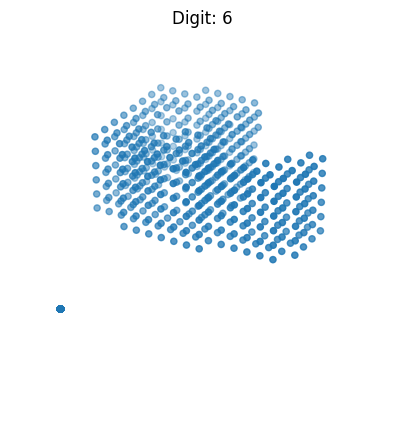

In [31]:
# index = np.random.randint(0, X_train.shape[0])
points = pointcloud_X_train[index]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.set_title(f"Digit: {y_train[index]}")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

### Converting dataset to TensorFlow tensors

In [30]:
def convert_to_dataset(X, y, batch_size=300, buffer_size=1, shuffle_size=0):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # Converting to TensorFlow Dataset
    dataset = dataset.map(lambda samples, labels: (tf.cast(samples, tf.float16), tf.cast(labels, tf.uint8))) # Optimizing data types
    if shuffle_size > 0:
        dataset = dataset.shuffle(shuffle_size)
    if batch_size > 0:
        dataset = dataset.batch(batch_size) # Creating batches with "batch_size" images
    if buffer_size > 0:
        dataset = dataset.prefetch(buffer_size) # Prefetching "buffer_size" batches
    

    return dataset

#### Voxels

In [ ]:
voxel_train_data = convert_to_dataset(voxel_X_train, y_train_dummy, buffer_size=0, 
                                      batch_size=300, shuffle_size=voxel_X_train.shape[0])
voxel_test_data = convert_to_dataset(voxel_X_test, y_test_dummy, buffer_size=0, 
                                     batch_size=150, shuffle_size=voxel_X_test.shape[0])

#### Point Clouds

In [32]:
pointcloud_train_data = convert_to_dataset(pointcloud_X_train, y_train_dummy, buffer_size=0, 
                                           batch_size=300, shuffle_size=pointcloud_X_train.shape[0])
pointcloud_test_data = convert_to_dataset(pointcloud_X_test, y_test_dummy, buffer_size=0, 
                                          batch_size=150, shuffle_size=pointcloud_X_test.shape[0])

2024-08-07 21:19:21.288866: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1200000000 exceeds 10% of free system memory.


In [33]:
# for x, y in train_df.take(1):
#     print(x.shape, y.shape)

for x, y in voxel_train_data.take(1):
    print(x.shape, y.shape)

(300, 16, 16, 16, 1) (300, 10)


2024-08-07 21:19:33.414153: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Defining the models

## Model from scratch

### CNN based on Point Cloud data

I tested many topologies, and i had the best individual performance based on the learning curve on the dense model and convolutional model.

So I decided to join both architetures to try getting the best features.

In [18]:
from keras.api.models import Model
from keras.api import layers, optimizers

def conv1d_layer(filters=32, kernel_size=3, conv_padding="same", activation="relu", input_layer=None, batch_norm=False, \
                 enable_pooling=False, pool_size=2, pool_strides=None, pool_padding="valid"):
    
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding=conv_padding)
    if input_layer is not None:
        x = x(input_layer)
    
    if batch_norm:
        x = layers.BatchNormalization(axis=1)(x)
        
    x = layers.Activation(activation)(x)

    if enable_pooling:
        x = layers.MaxPool1D(pool_size=pool_size, strides=pool_strides, padding=pool_padding)(x)
    
    return x

def dense_layer(units=32, activation="relu", input_layer=None, batch_norm=False, dropout=0.0):
    x = layers.Dense(units=units)
    if input_layer is not None:
        x = x(input_layer)
    if batch_norm:
        x = layers.BatchNormalization(axis=1)(x)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)

    x = layers.Activation(activation)(x)
    return x

def create_model_2d(input_shape=(1000, 3)):
    inputs = layers.Input(shape=input_shape)

    hidden1 = dense_layer(units=256, activation="linear", input_layer=inputs, batch_norm=True, dropout=0.5)
    hidden1 = dense_layer(units=256, activation="linear", input_layer=hidden1, batch_norm=True, dropout=0.5)
    hidden1 = layers.GlobalAveragePooling1D()(hidden1)
    hidden1 = dense_layer(units=256, activation="relu", input_layer=hidden1, batch_norm=True, dropout=0.25)


    conv2 = conv1d_layer(input_layer=inputs, filters=128, kernel_size=3, conv_padding="same", activation="relu", batch_norm=False, 
                        enable_pooling=True, pool_size=2)
    conv2 = layers.GlobalMaxPooling1D()(conv2)
    hidden2 = dense_layer(units=256, activation="relu", input_layer=conv2, batch_norm=False, dropout=0.25)

    head = layers.Add()([hidden1, hidden2])

    head = dense_layer(units=256, activation="relu", input_layer=head, batch_norm=True, dropout=0.3)
    head = dense_layer(units=10, activation="softmax", input_layer=head, batch_norm=False)

    model = Model(inputs=inputs, outputs=head)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizers.Adam(learning_rate=0.001, epsilon=0.0001),
        metrics=["categorical_accuracy"],
    )

    return model

model = create_model_2d()
model.name = "pointcloud_from_scratch"
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1000, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1000, 256) │      1,024 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1000, 256) │      4,000 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1000, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1000, 256) │          0 │ dropout[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1000, 256) │     65,792 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 256) │      4,000 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1000, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1000, 128) │      1,280 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1000, 256) │          0 │ dropout_1[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1000, 128) │          0 │ conv1d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ activation_1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 500, 128)  │          0 │ activation_3[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ max_pooling1d[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     33,024 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256)       │          0 │ dropout_2[0][0] 

 Total params: 245,322 (958.29 KB)

 Trainable params: 240,298 (938.66 KB)

 Non-trainable params: 5,024 (19.62 KB)

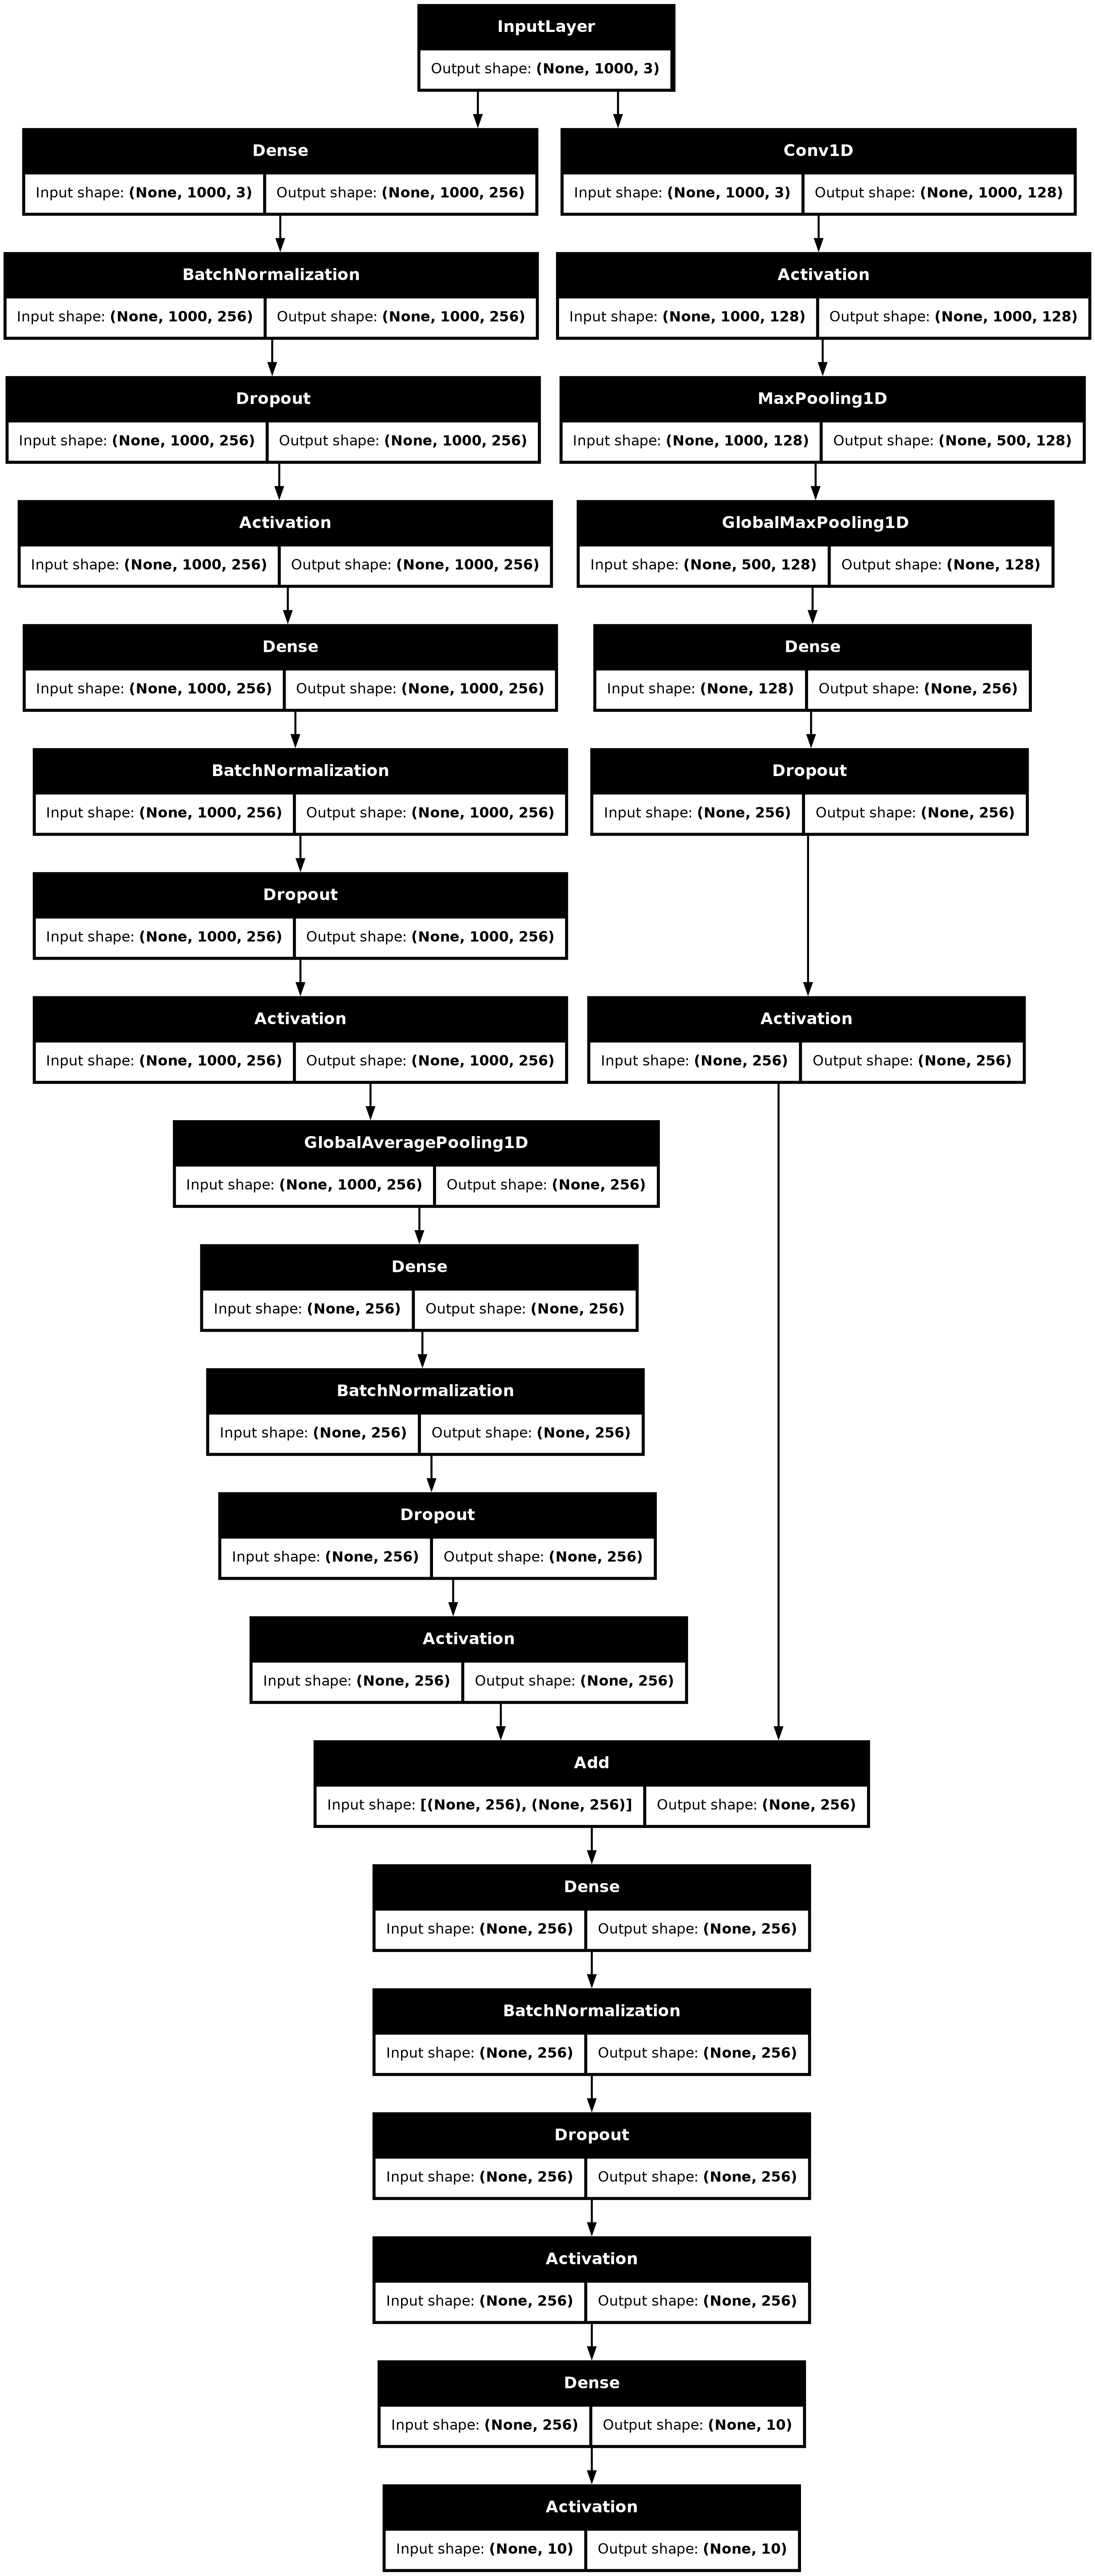

In [20]:
# from keras.api.utils import plot_model

# plot_model(model=model, to_file=os.path.join(f"{model.name}.png"), show_shapes=True)

### CNN based on Voxelized data

* Here i used concept of volumetric CNN

In [25]:
from keras.api.models import Model
from keras.api import layers, optimizers

def create_model_3d(input_shape=(16, 16, 16, 1)):
    # model
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv3D(filters=32, kernel_size=5, padding="same", activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2, padding="valid")(x)

    x = layers.Conv3D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2, padding="valid")(x)

    x = layers.Conv3D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2, padding="same", strides=1)(x)

    x = layers.GlobalAveragePooling3D()(x)
#     x = layers.GlobalMaxPooling3D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(10, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = optimizers.Adam(
        epsilon=0.01, 
        learning_rate=0.005,
        weight_decay=10e-3
    )

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

voxel_model = create_model_3d()
voxel_model.name = "voxel_from_strach"
voxel_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 16, 16, 16, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 16, 16, 16, 32) │         4,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 8, 8, 8, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 8, 8, 8, 64)    │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 4, 4, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 4, 4, 4, 128)   │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 4, 4, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 614,538 (2.34 MB)

 Trainable params: 614,538 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# from keras.api.utils import plot_model

# plot_model(model=voxel_model, to_file=os.path.join(f"{voxel_model.name}.png"), show_shapes=True)

## Pre-defined models

### Multiview CNN

* https://arxiv.org/pdf/1505.00880

![Multiview CNN](resources/multiview_cnn.png)

In [45]:
# https://en.wikipedia.org/wiki/Rotation_matrix#In_three_dimensions
# https://en.wikipedia.org/wiki/Aircraft_principal_axes

def rotate_pointcloud(pointcloud, angle_x_deg=0, angle_y_deg=0, angle_z_deg=0):
    
    alpha = np.deg2rad(angle_x_deg)
    beta = np.deg2rad(angle_y_deg)
    gama = np.deg2rad(angle_z_deg)

    R = np.array([
        [
            np.cos(alpha)*np.cos(beta), 
            np.cos(alpha)*np.sin(beta)*np.sin(gama) - np.sin(alpha)*np.cos(gama), 
            np.cos(alpha)*np.sin(beta)*np.cos(gama) + np.sin(alpha)*np.sin(gama)
        ],
        [
            np.sin(alpha)*np.cos(beta), 
            np.sin(alpha)*np.sin(beta)*np.sin(gama) + np.cos(alpha)*np.cos(gama), 
            np.sin(alpha)*np.sin(beta)*np.cos(gama) - np.cos(alpha)*np.sin(gama)
        ],
        [
            -np.sin(beta), 
            np.cos(beta)*np.sin(gama), 
            np.cos(beta)*np.cos(gama)
        ]
    ])

    return tf.linalg.matmul(pointcloud, R)

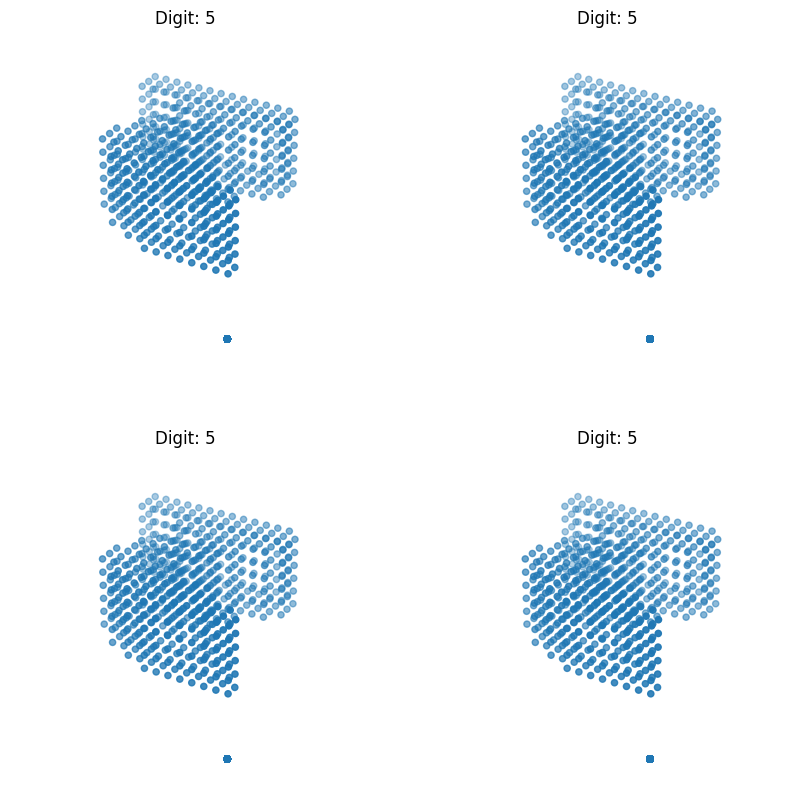

In [71]:
rotations = [0, 90, 180, 270]
pointcloud = pointcloud_X_train[0]
label = y_train[0]

fig = plt.figure(figsize=(10, 10))

for i, angle in enumerate(rotations):
    rotated_pc = rotate_pointcloud(pointcloud, angle_x_deg=-90, angle_y_deg=0, angle_z_deg=0)
    ax = fig.add_subplot(221+i, projection="3d")
    ax.set_title(f"Digit: {label}")
    ax.scatter(rotated_pc[:, 0], rotated_pc[:, 1], rotated_pc[:, 2])
    ax.set_axis_off()

plt.show()

In [ ]:
# Reender four 2D images from a 3D point cloud
NUM_VIRTUAL_CAM = 4

# Create feature explorer CNN

# Create classifier CNN 

### PointNet Architeture

https://arxiv.org/pdf/1612.00593

In [6]:
from keras.api.models import Model
from keras.api import layers
from keras.api.regularizers import Regularizer
from keras.api.optimizers import Adam
from keras.api import ops

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

def dense_bn(x, filters, dropout=0):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    return layers.Activation("relu")(x)


class OrthogonalRegularizer(Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = ops.eye(num_features, dtype=np.float16)

    def __call__(self, x):
        x = ops.reshape(x, (-1, self.num_features, self.num_features))
        xxt = ops.tensordot(x, x, axes=(2, 2))
        xxt = ops.reshape(xxt, (-1, self.num_features, self.num_features))
        return ops.sum(self.l2reg * ops.square(xxt - self.eye))

def tnet(inputs, num_features):
    """The T-net aims to learn an affine transformation matrix by its own mini network."""
    # Initialise bias as the identity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256, dropout=0.25)
    x = dense_bn(x, 128, dropout=0.25)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)

    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])


inputs = layers.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 64)
x = conv_bn(x, 64)
x = tnet(x, 64)
x = conv_bn(x, 64)
x = conv_bn(x, 128)
x = conv_bn(x, 1024)
x = layers.GlobalMaxPool1D()(x)
x = dense_bn(x, 512, dropout=0.25)
x = dense_bn(x, 256, dropout=0.25)
x = layers.Dense(10, activation="softmax")(x)


pointnet_model = Model(inputs=inputs, outputs=x)
pointnet_model.name = "pointnet_model"
pointnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)

pointnet_model.summary()

I0000 00:00:1723121868.440505   33514 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723121868.479137   33514 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723121868.479196   33514 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723121868.481455   33514 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723121868.481505   33514 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "pointnet_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2000, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2000, 32)  │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2000, 32)  │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 2000, 64)  │      2,112 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 64)  │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 2000, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2000, 512) │     33,280 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 512) │      2,048 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 2000, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_2[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256)       │          0 │ dropout[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ dropout_1[0][0]   │
│ (Activation)        │                   │            │                 

 Total params: 1,755,059 (6.70 MB)

 Trainable params: 1,746,867 (6.66 MB)

 Non-trainable params: 8,192 (32.00 KB)

# Training the Models

## Point Cloud model from scratch

In [26]:
from keras.api.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1
)

def lr_scheduler_fn(epoch, lr):
    lr_decay_rate = 0.8
    epoch_trigger = epoch > 0 and epoch % 25 == 0
    lr_limit = lr > 0.0001

    if epoch_trigger and lr_limit:
        return lr * lr_decay_rate
    
    return lr

lr_scheduler = LearningRateScheduler(
    lr_scheduler_fn,
    verbose=0
)

model_checkpoint = ModelCheckpoint(
    f"models/mnist/3d_point_cloud/{model.name}.weights.h5",
    monitor="val_loss",
    save_best_only=True
)

model_history = model.fit(
    pointcloud_train_data,
    validation_data=pointcloud_test_data,
    epochs=120,
    # batch_size=350,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/120
 1/29 ━━━━━━━━━━━━━━━━━━━━ 9:28 20s/step - categorical_accuracy: 0.0971 - loss: 2.9450

I0000 00:00:1722971546.967566     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 606ms/step - categorical_accuracy: 0.1608 - loss: 2.5440 - val_categorical_accuracy: 0.1660 - val_loss: 2.4204 - learning_rate: 0.0010
Epoch 2/120
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - categorical_accuracy: 0.2683 - loss: 2.0322 - val_categorical_accuracy: 0.1725 - val_loss: 2.3427 - learning_rate: 0.0010
Epoch 3/120
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - categorical_accuracy: 0.3289 - loss: 1.8712 - val_categorical_accuracy: 0.1510 - val_loss: 2.2441 - learning_rate: 0.0010
Epoch 4/120
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - categorical_accuracy: 0.3455 - loss: 1.8183 - val_categorical_accuracy: 0.2410 - val_loss: 2.0868 - learning_rate: 0.0010
Epoch 5/120
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - categorical_accuracy: 0.3663 - loss: 1.7512 - val_categorical_accuracy: 0.3225 - val_loss: 1.9637 - learning_rate: 0.0010
Epoch 6/120
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - categorical_accuracy: 0.3947 - loss: 1.7038 - val_categorical_accuracy: 0.38

## Voxelized model from scratch

In [27]:
from keras.api.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1
)

def lr_scheduler_fn(epoch, lr):
    lr_decay_rate = 0.8
    epoch_trigger = epoch > 0 and epoch % 25 == 0
    lr_limit = lr > 0.0001

    if epoch_trigger and lr_limit:
        return lr * lr_decay_rate
    
    return lr

lr_scheduler = LearningRateScheduler(
    lr_scheduler_fn,
    verbose=0
)

model_checkpoint = ModelCheckpoint(
    f"models/mnist/3d_point_cloud/{voxel_model.name}.weights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True
)

voxel_model_history = voxel_model.fit(
    voxel_train_data,
    validation_data=voxel_test_data,
    epochs=120,
    # batch_size=350,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
    verbose=1
)

Epoch 1/120
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - categorical_accuracy: 0.1097 - loss: 2.3023 - val_categorical_accuracy: 0.1260 - val_loss: 2.2999 - learning_rate: 0.0050
Epoch 2/120
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - categorical_accuracy: 0.1136 - loss: 2.3002 - val_categorical_accuracy: 0.1260 - val_loss: 2.2981 - learning_rate: 0.0050
Epoch 3/120
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.1180 - loss: 2.2986 - val_categorical_accuracy: 0.1260 - val_loss: 2.2966 - learning_rate: 0.0050
Epoch 4/120
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.1203 - loss: 2.2974 - val_categorical_accuracy: 0.1335 - val_loss: 2.2935 - learning_rate: 0.0050
Epoch 5/120
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.1396 - loss: 2.2931 - val_categorical_accuracy: 0.2005 - val_loss: 2.2840 - learning_rate: 0.0050
Epoch 6/120
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - categorical_accuracy: 0.1640 - loss: 2.2844 - val_categorical_ac

## PointNet Model

In [ ]:
from keras.api.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=10,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath="models/mnist/3d_point_cloud/pointnet_model.weights.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)

if os.path.exists("models/mnist/3d_point_cloud/pointnet_model.weights.h5"):
    weights = pointnet_model.load_weights("models/mnist/3d_point_cloud/pointnet_model.weights.h5")

pointnet_history = pointnet_model.fit(
    # pointcloud_train_data,
    x=pointcloud_X_train,
    y=y_train_dummy,
    # validation_data=pointcloud_test_data,
    validation_data=(pointcloud_X_test, y_test_dummy),
    epochs=20,
    batch_size=150,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Comparing the results

In [17]:
point_cloud_hist = pd.DataFrame(model_history.history)
voxel_hist = pd.DataFrame(voxel_model_history.history)
pointnet_hist = pd.DataFrame(pointnet_history.history)

plt.figure(figsize=(12, 12))

plt.subplot(321)
plt.xlim(left=0, right=120)
plt.title("Point Cloud - Loss")
plt.plot(point_cloud_hist[["loss", "val_loss"]], label=["loss", "val_loss"])
plt.legend()

plt.subplot(322)
plt.xlim(left=0, right=120)
plt.title("Point Cloud - Accuracy")
plt.plot(point_cloud_hist[["categorical_accuracy", "val_categorical_accuracy"]], label=["categorical_accuracy", "val_categorical_accuracy"])
plt.legend()

plt.subplot(323)
plt.xlim(left=0, right=120)
plt.title("Voxel - Loss")
plt.plot(voxel_hist[["loss", "val_loss"]], label=["loss", "val_loss"])
plt.legend()

plt.subplot(324)
plt.xlim(left=0, right=120)
plt.title("Voxel - Accuracy")
plt.plot(voxel_hist[["categorical_accuracy", "val_categorical_accuracy"]], label=["categorical_accuracy", "val_categorical_accuracy"])
plt.legend()

plt.subplot(325)
plt.xlim(left=0, right=120)
plt.title("PointNet - Loss")
plt.plot(pointnet_hist[["loss", "val_loss"]], label=["loss", "val_loss"])
plt.legend()

plt.subplot(326)
plt.xlim(left=0, right=120)
plt.title("PointNet - Accuracy")
plt.plot(pointnet_hist[["categorical_accuracy", "val_categorical_accuracy"]], label=["categorical_accuracy", "val_categorical_accuracy"])
plt.legend()

plt.show()

NameError: name 'model_history' is not defined

#### The Voxel Model fitted better but we still get some overfitting while training the Voxel Model. The Point Cloud Model seems to have lower overfitting but it get stuck at some point on learning about the points.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
****** Point Cloud Model *******
              precision    recall  f1-score   support

           0       0.47      0.72      0.57       170
           1       0.90      0.96      0.93       252
           2       0.45      0.40      0.43       232
           3       0.39      0.35      0.37       214
           4       0.53      0.46      0.49       220
           5       0.58      0.30      0.40       174
           6       0.53      0.60      0.56       174
           7       0.53      0.65      0.58       198
           8       0.40      0.36      0.38       178
           9       0.49      0.53      0.51       188

    accuracy                           0.54      2000
   macro avg       0.53      0.53      0.52      2000
weighted avg       0.54      0.54      0.53      2000


****** Voxel Model *******
              precision    recall  f1-score   support

           0       0.91      0.92      0.92    

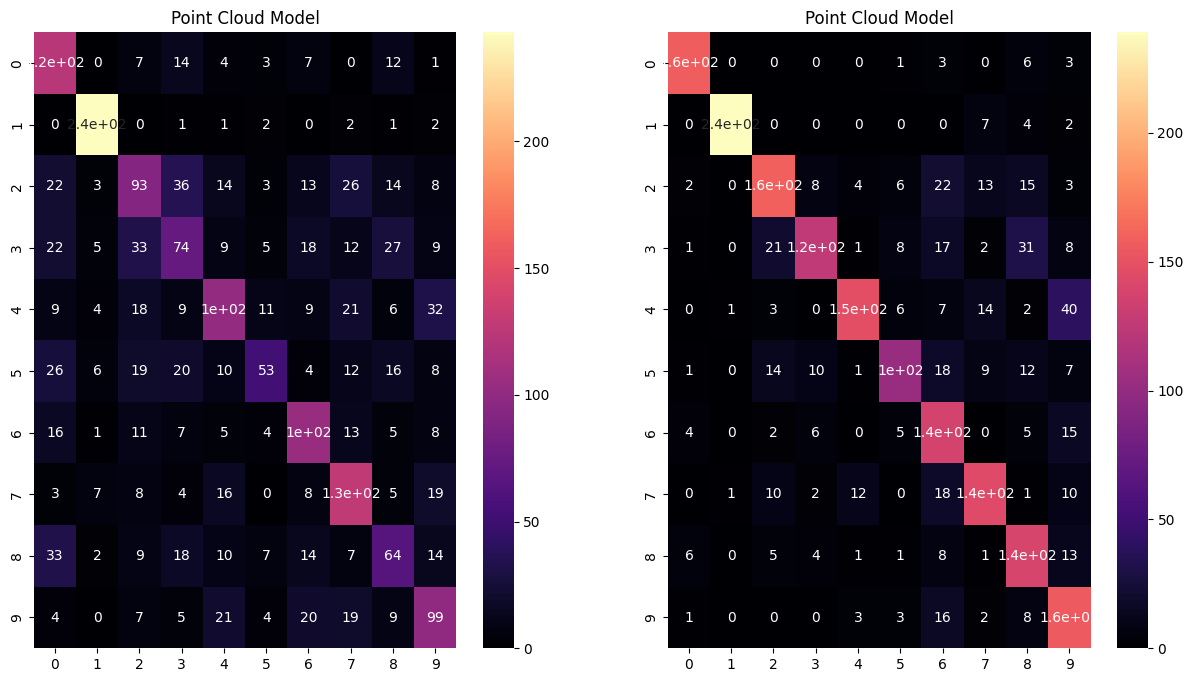

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
from seaborn import heatmap

pred = model.predict(pointcloud_X_test)
voxel_pred = voxel_model.predict(voxel_X_train)
pointnet_pred = pointcloud_model.predict(pointcloud_X_test)

report = classification_report(y_pred=np.argmax(pred, axis=1), y_true=np.argmax(y_test_dummy, axis=1))
voxel_report = classification_report(y_pred=np.argmax(voxel_pred, axis=1), y_true=np.argmax(y_test_dummy, axis=1))
pointnet_report = classification_report(y_pred=np.argmax(pointnet_pred, axis=1), y_true=np.argmax(y_test_dummy, axis=1))

print("****** Point Cloud Model *******")
print(report)

print("\n****** Voxel Model *******")
print(voxel_report)

print("\n****** PointNet Model *******")
print(voxel_report)

cm = confusion_matrix(y_pred=np.argmax(pred, axis=1), y_true=np.argmax(y_test_dummy, axis=1))
voxel_cm = confusion_matrix(y_pred=np.argmax(voxel_pred, axis=1), y_true=np.argmax(y_test_dummy, axis=1))
poitnet_cm = confusion_matrix(y_pred=np.argmax(pointnet_pred, axis=1), y_true=np.argmax(y_test_dummy, axis=1))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
ax[0].set_title("Point Cloud Model")
heatmap(cm, annot=True, cmap="magma", ax=ax[0])

ax[1].set_title("Point Cloud Model")
heatmap(voxel_cm, annot=True, cmap="magma", ax=ax[1])

ax[2].set_title("PointNet Model")
heatmap(poitnet_cm, annot=True, cmap="magma", ax=ax[2])

plt.show()

## Saving the model

In [39]:
score = model.evaluate(pointcloud_test_data)[1]
print("Score: ", score)

file_name = f"model_{score*100:.0f}_pct.keras"
# model.save(
#     file_name)
# )

score = voxel_model.evaluate(voxel_test_data)[1]
print("Score: ", score)

file_name = f"model_{score*100:.0f}_pct.keras"
# voxel_model.save(
#     file_name)
# )

score = pointnet_model.evaluate(pointcloud_test_data)[1]
print("Score: ", score)

file_name = f"model_{score*100:.0f}_pct.keras"
# poitnet_cm.save(
#     file_name)
# )

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.5437 - loss: 1.2536
Score:  0.5404999852180481
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.7626 - loss: 0.7886
Score:  0.7519999742507935
